In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from DTA.utils import load_inclusion_coordinates
from DTA.density import parse_tcl_dat_file, aggregate_density_enrichment_scores, load_replica_counts, valid_Dimensions
from DTA.plotting import make_density_enrichment_heatmap, make_custom_colormap, plot_histogram, outline_site, plot_titration_curve, HeatmapSettings
from DTA.Site import Site
from DTA.SymmetricSite import SymmetricSite
from DTA.SiteAcrossReplicas import SiteAcrossReplicas

***

## EDIT THESE SETTINGS

In [2]:
root_path = Path("./sample_data/sample_outputs/PC_CL").resolve() # The directory containing your replica subdirectories
DPPC_root_path = root_path.joinpath("../DPPC").resolve() # The directory containing the outputs of PolarDensityBin from your DPPC + protein simulation
DPPC_bulk_root_path = root_path.joinpath("../DPPC_bulk/").resolve() # The directory that will contain the outputs of do_get_counts.tcl from your DPPC bulk simulation
bulk_system_root_path = root_path.joinpath("../PC_CL_bulk").resolve() # The directory that will contain the outputs of do_get_counts.tcl from your bulk simulation
system_name = "CL" # The filestem that PolarDensityBin used.
replicas = ["rep1", "rep2"] # names of replica subdirectories, located in the "root_path" directory
helix_definitions = root_path.joinpath(replicas[0]) #where are the coordinates for the transmembrane helices?
max_enrichment = 5 # how high do you want your heat map to go?
row_names = ["DPOCL\nheadgroups"] # What label(s) do you want on the row(s) of your heatmap?
col_names = ["Outer", "Inner"] # What label(s) do you want on the column(s) of your heatmap?

***

## STEP A: MAKE A HEATMAP OF DENSITY ENRICHMENT
#### Step A0: Run PolarDensityBin on your simulation systems
#### Step A1: Make a heatmap of the outputs

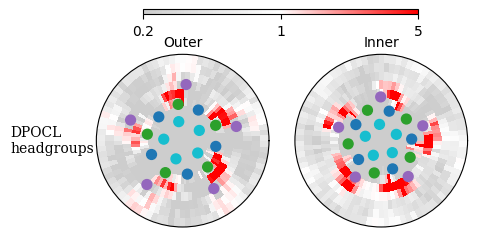

In [3]:
# Load in data
helices = load_inclusion_coordinates(helix_definitions)
avg_enrichments = []
for leaf in ["upp", "low"]:
    rep_list = []
    for rep in replicas:
        rep_path = root_path.joinpath(rep, f"{system_name}.{leaf}.avg.dat")
        rep_list.append(rep_path)
    avg_enrichment_over_reps, grid_dims = aggregate_density_enrichment_scores(rep_list)
    avg_enrichments.append(avg_enrichment_over_reps)

# Save heatmap settings
heatmap_settings = HeatmapSettings(row_names, col_names, (2.5, 5.5), max_enrichment, grid_dims)
heatmap_settings.colormap = make_custom_colormap()

# Plot
fig, axes = make_density_enrichment_heatmap(avg_enrichments, helices, heatmap_settings)
plt.show()
plt.clf()
plt.close()

***

## STEP B: MAKE A SYMMETRIC SITE

#### Step B1: Create a Site object.
Give it a name, specify the leaflet (1=outer, 2=inner), and the temperature (in K).

In [4]:
site1 = Site(name="inner M1-M4", leaflet_id=2, temperature=320) # step 1

#### Step B2: Add a list of bin coordinates
Bin tuples are (r, theta), numbered starting from the center mvoing out (r) and 3 o'clock moving counterclockwise (theta) \
We usually take a guess and then revise our guess based on what the outline looks like in step B4.

In [5]:
site1.bin_coords = [(5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (5, 18), (5, 19), (5, 20), (5, 21), (5, 22), (5, 23), (6, 18), (6, 19), (6, 20), (6, 21), (6, 22), (6, 23)] # step 2

#### Step B3: Make a SymmetricSite object.
- Specify the symmetry. We chose five-fold because we simulated a pentamer.
- Give it your Site object as the base_site.
- Tell it how many theta bins are in your lattice.

In [6]:
symm_site1 = SymmetricSite(symmetry=5, base_site=site1, Ntheta=grid_dims.Ntheta) #step 3

#### Step B4: Outline the site on the heatmap with outline_site()

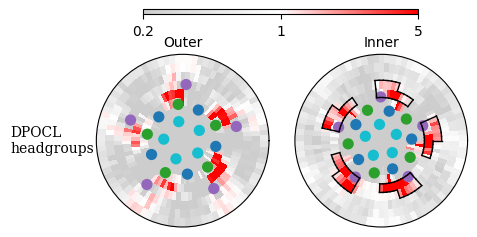

In [7]:
fig, axes = make_density_enrichment_heatmap(avg_enrichments, helices, heatmap_settings)

axes[site1.leaflet_id - 1] = outline_site(axes[site1.leaflet_id - 1], symm_site1, grid_dims) #step 4

plt.show()
plt.clf()
plt.close()

#### Step B5 (optional): If you don't like the placement of your site, go back to Step B2 

#### Step B6: Load all the counts outputs from PolarDensityBin from all your replicas 

In [8]:
replica_counts_list = load_replica_counts(root_path, replicas, system_name, site1.leaflet_id)

#### Step B7: Create a SiteAcrossReplicas object to store all this data

In [9]:
symm_site_across_replicas_1 = SiteAcrossReplicas(replica_counts_list, base_site=symm_site1)

***

## Step C: Find accessible area of site

#### Step C0: Run PolarDensityBin on your 100% DPPC + Protein system 
Use the same settings that you used for the original system.

#### Step C1: Load the outputs and create a duplicate Site and SymmetricSite to hold your DPPC data

In [10]:
# load the outputs
DPPC_outer = DPPC_root_path.joinpath(f"DPPC.upp.dat")
DPPC_inner = DPPC_root_path.joinpath(f"DPPC.low.dat")

DPPC_outer_counts, _, _ = parse_tcl_dat_file(DPPC_outer, bulk=False)
DPPC_inner_counts, _, _ = parse_tcl_dat_file(DPPC_inner, bulk=False)

# create a duplicate Site and SymmetricSite
DPPC_site1 = Site(name=f"{site1.name}_DPPC", leaflet_id=site1.leaflet_id, temperature=site1.temperature)
DPPC_site1.bin_coords = site1.bin_coords
DPPC_symm_site1 = SymmetricSite(symmetry=symm_site1.symmetry, base_site=DPPC_site1, Ntheta=grid_dims.Ntheta)

#### Step C2: add the DPPC counts from the correct leaflet
If you made your original site in the outer leaflet, use DPPC_outer_counts!

In [11]:
DPPC_symm_site1.update_counts_histogram(bulk=False, counts_data=DPPC_inner_counts)

#### Step C3a: Calculate the geometric area of the site

In [12]:
site1_geom_area = round(DPPC_site1.calculate_geometric_area(grid_dims.dr, grid_dims.dtheta))
print(f"Initial guess for accessible area is geometric area: {site1_geom_area} A^2")

Initial guess for accessible area is geometric area: 174 A^2


#### Step C3b: Plot the histogram of DPPC beads in your site over the course of the DPPC simulation

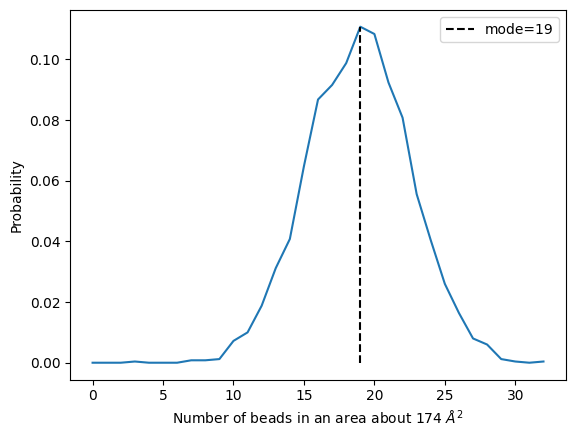

In [13]:
fig,ax = plt.subplots()
ax = plot_histogram(ax, DPPC_symm_site1.site_counts_histogram, site1_geom_area, plot_probability=True)
site_mode = np.argmax(DPPC_symm_site1.site_counts_histogram)
plt.show()
plt.clf()
plt.close()

#### Step C4a: Edit density_threshold_affinity/accessible_area/do_get_counts.tcl to run on your DPPC bulk system with the area of your site, 
#### provided in step C3a
#### Step C4b: Load your bulk DPPC simulation (no protein) in VMD and source do_get_counts.tcl

#### Step C5: Load the bulk counts into this notebook

In [14]:
DPPC_bulk_counts, _, _ = parse_tcl_dat_file(DPPC_bulk_root_path.joinpath(f"DPPC_counts_{site1_geom_area}.out"), bulk=True) #step C5

#### Step C6: Update the bulk counts of DPPC_symm_site1

In [15]:
DPPC_symm_site1.update_counts_histogram(True, DPPC_bulk_counts) #step C6

#### Step C7: Plot the distribution

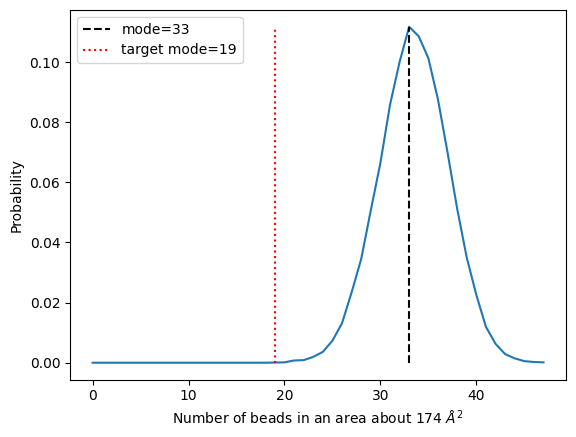

In [16]:
fig,ax = plt.subplots()
ax = plot_histogram(ax, DPPC_symm_site1.bulk_counts_histogram, f"{site1_geom_area}", bulk_mode=site_mode, plot_probability=True, show_target=True) #step C7
plt.show()
plt.clf()
plt.close()

#### Step C8a: Rerun do_get_counts.tcl with a better estimate for the accessible area

In [17]:
better_guess = 96

#### Step C8b: Plot the new distribution

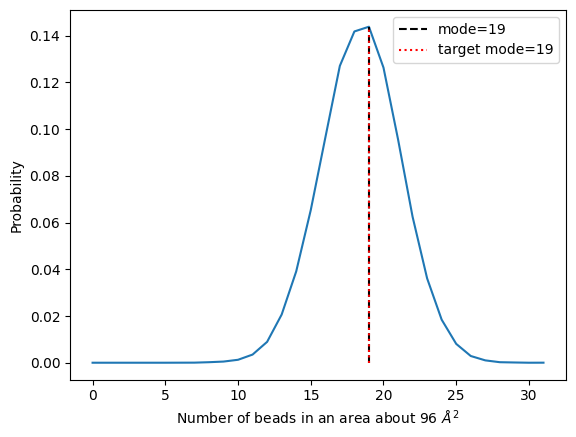

In [18]:
DPPC_bulk_counts, _, _ = parse_tcl_dat_file(DPPC_bulk_root_path.joinpath(f"DPPC_counts_{better_guess}.out"), bulk=True)
DPPC_symm_site1.update_counts_histogram(True, DPPC_bulk_counts)
fig,ax = plt.subplots()
ax = plot_histogram(ax, DPPC_symm_site1.bulk_counts_histogram, better_guess, bulk_mode=site_mode, plot_probability=True, show_target=True)
plt.show()
plt.clf()
plt.close()

#### Step C8c: Does the mode from C8b match the mode from C3b?
#### If yes, congratulations! You have identified the accessible area of your site. 
#### If no, try running do_get_counts with a smaller area.
#### Repeat step C8b, but replace the number with the smaller area you tried.

#### Step C8d: Enter your final "accessible area" number below.

In [19]:
accessible_area = 96

***

## Step D: Calculate your Density-Threshold Affinity

#### Step D0: Run do_get_counts.tcl on your bulk simulation
Modify do_get_counts.tcl to apply to your non-DPPC bulk simulation and use the accessible area from step C8d.\
Open VMD, load your bulk trajectory, and source do_get_counts.tcl.

#### Step D1: Specify the path to the outputs from step D0

In [20]:
bulk_counts_path = bulk_system_root_path.joinpath(f"{system_name}_counts_{accessible_area}.out")

#### Step D2: Load the bulk counts

In [21]:
bulk_counts_list, _, _ = parse_tcl_dat_file(bulk_counts_path, bulk=True)

#### Step D3: Add the bulk counts to your SiteAcrossReplicas object

In [22]:
symm_site_across_replicas_1.update_counts_histogram(bulk=True, counts_data=bulk_counts_list)

#### Step D4: Plot the bulk distribution

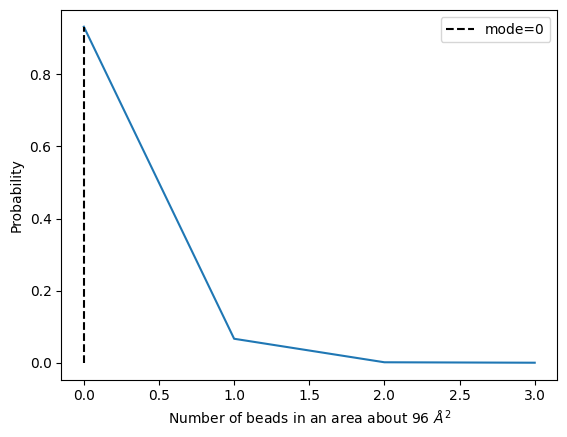

In [23]:
fig, ax = plt.subplots()
ax = plot_histogram(ax, symm_site_across_replicas_1.bulk_counts_histogram, accessible_area, plot_probability=True)
plt.show()
plt.clf()
plt.close()

### Step E: Calculate your density-threshold affinity!

#### Step E1: Calculate the raw numbers

In [24]:
print(f"Overall binding affinity dG is {round(symm_site_across_replicas_1.dG, 2)} kcal/mol")
print(f"st.dev is plus or minus {round(symm_site_across_replicas_1.dG_std, 2)} kcal/mol")

Overall binding affinity dG is -1.45 kcal/mol
st.dev is plus or minus 0.05 kcal/mol


#### Step E2: Plot a titration curve

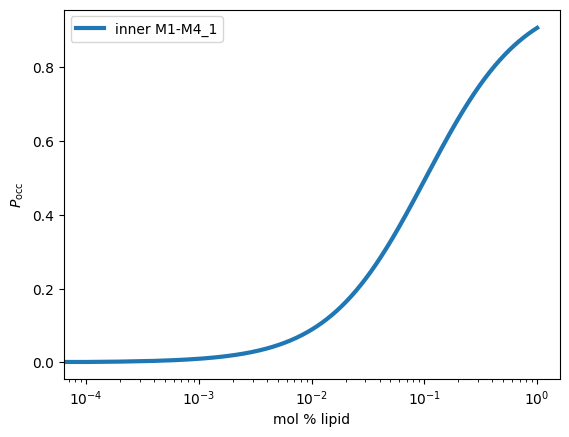

In [25]:
fig, ax = plt.subplots()
ax = plot_titration_curve(ax, symm_site_across_replicas_1.dG, symm_site_across_replicas_1.dG_std, site1.temperature, site1.name, True, 'CI', symm_site1.symmetry * len(replicas))
ax.set_xscale('log')
ax.legend()
ax.set_xlabel('mol % lipid')
ax.set_ylabel(r'$P_{\mathrm{occ}}$')
plt.show()
plt.clf()
plt.close()